In [1]:
# 1. Import thư viện cần thiết ~33s
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Mounted at /content/drive


In [77]:
# 2. Đọc file csv
company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/IMP.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/OPC.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/VMD.csv'
df = pd.read_csv(company_csv)
df

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2014-01-02,10760,10790,10760,10790,2410,IMP
1,1,2014-01-03,10760,10840,10670,10840,13010,IMP
2,2,2014-01-06,10870,11560,10870,11540,55630,IMP
3,3,2014-01-07,11400,11540,11330,11540,20980,IMP
4,4,2014-01-08,11370,11830,11330,11800,43410,IMP
...,...,...,...,...,...,...,...,...
2462,2462,2023-12-04,54700,55500,54400,55300,24800,IMP
2463,2463,2023-12-05,55200,55200,54600,55000,10200,IMP
2464,2464,2023-12-06,55000,55200,54900,55200,26600,IMP
2465,2465,2023-12-07,54900,55900,54900,55200,29200,IMP


In [78]:
# và gắng index với giá Close cho df1
df1 = df.reset_index()['close']
df1

0       10790
1       10840
2       11540
3       11540
4       11800
        ...  
2462    55300
2463    55000
2464    55200
2465    55200
2466    55200
Name: close, Length: 2467, dtype: int64

In [79]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
# scaler
df1

array([[0.        ],
       [0.00072993],
       [0.01094891],
       ...,
       [0.64832117],
       [0.64832117],
       [0.64832117]])

In [80]:
# 4. Chia train test 7 - 2 - 1 len() = 2467 => 7 - 2 - 1 = 1726 493 248
train_size = int(0.8 * len(df1)) #1726
test_size = int(0.1 * len(df1)) #493
val_size = len(df1) - train_size - test_size #248

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# print(train_size , test_size , val_size)
# print(train_data)
# print(test_data)
# print(val_data)

In [81]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [82]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [83]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [84]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [85]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
30/30 [==============================] - 14s 290ms/step - loss: 0.0297 - val_loss: 0.0030
Epoch 2/100
30/30 [==============================] - 5s 167ms/step - loss: 0.0015 - val_loss: 0.0057
Epoch 3/100
30/30 [==============================] - 6s 191ms/step - loss: 6.4642e-04 - val_loss: 0.0036
Epoch 4/100
30/30 [==============================] - 7s 218ms/step - loss: 5.9331e-04 - val_loss: 0.0032
Epoch 5/100
30/30 [==============================] - 5s 166ms/step - loss: 5.9250e-04 - val_loss: 0.0026
Epoch 6/100
30/30 [==============================] - 7s 226ms/step - loss: 5.7298e-04 - val_loss: 0.0030
Epoch 7/100
30/30 [==============================] - 6s 188ms/step - loss: 5.4035e-04 - val_loss: 0.0022
Epoch 8/100
30/30 [==============================] - 5s 166ms/step - loss: 5.7212e-04 - val_loss: 0.0024
Epoch 9/100
30/30 [==============================] - 7s 246ms/step - loss: 5.3785e-04 - val_loss: 0.0026
Epoch 10/100
30/30 [==============================] - 5s 169ms

In [86]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 38ms/step


In [87]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [88]:
# 11. Chuẩn hóa dữ liệu y_train, ytest,yval về lại VND
y_train = y_train.reshape(-1, 1)
ytest = ytest.reshape(-1, 1)
yval = yval.reshape(-1, 1)

y_train = scaler.inverse_transform(y_train)
ytest = scaler.inverse_transform(ytest) #actual value
yval = scaler.inverse_transform(yval) #acutual value

In [89]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# def evaluateModel(validate, testt)
#   valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
#   test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
#   print('Validation RMSE:', valid_rmse)
#   print('Testing RMSE:', test_rmse)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MAE, RMSE, R-square cho testing
mae_test = mean_absolute_error(ytest, y_pred)
rmse_test = np.sqrt(mean_squared_error(ytest, y_pred))
mape_test = calculate_mape(ytest, y_pred)
r_squared_test = r2_score(ytest, y_pred)

# Tính MAE, RMSE cho validation
mae_val = mean_absolute_error(yval, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(yval, y_pred_val))
mape_val = calculate_mape(yval, y_pred_val)
r_squared_val = r2_score(yval, y_pred_val)

# In kết quả
print('---------VALIDATE----------')
print("MAE:", round(mae_val, 3))
print("RMSE:", round(rmse_val, 3))
print("MAPE:", round(mape_val, 3))
print("R-squared:", round(r_squared_val, 3))
print('--------------------------')
print('---------TEST----------')
print("MAE:", round(mae_val, 3))
print("RMSE:", round(rmse_test, 3))
print("MAPE:", round(mape_test, 3))
print("R-squared:", round(r_squared_test, 3))
print('-------------------')


---------VALIDATE----------
MAE: 940.072
RMSE: 1318.114
MAPE: 1.541
R-squared: 0.935
--------------------------
---------TEST----------
MAE: 940.072
RMSE: 1472.944
MAPE: 1.93
R-squared: 0.906
-------------------


In [90]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=187
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        # print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.50978102 0.5140146  0.5140146  0.52014599 0.53313869 0.51664234
 0.52759124 0.50715328 0.50978102 0.5249635  0.50087591 0.50233577
 0.49343066 0.48788321 0.48715328 0.48992701 0.50029197 0.49883212
 0.49883212 0.50029197 0.5140146  0.52072993 0.52072993 0.51664234
 0.52072993 0.54131387 0.54408759 0.54131387 0.58934307 0.59065693
 0.54686131 0.54277372 0.56875912 0.56189781 0.58934307 0.60029197
 0.59620438 0.60715328 0.60437956 0.60306569 0.6140146  0.60569343
 0.60846715 0.60029197 0.60437956 0.60437956 0.60437956 0.59474453
 0.57430657 0.58788321 0.59620438 0.58248175 0.59620438 0.60029197
 0.60846715 0.60992701 0.60715328 0.60306569 0.63591241 0.67839416
 0.66467153 0.66058394 0.66058394 0.66467153 0.66189781 0.66189781
 0.65927007 0.65927007 0.64131387 0.6550365  0.66467153 0.66058394
 0.66467153 0.67839416 0.70437956 0.71124088 0.6880292  0.6989781
 0.71810219 0.71532847 0.71270073 0.72627737 0.72627737 0.71956204
 0.6989781  0.75781022 0.82087591 0.82642336 0.8071

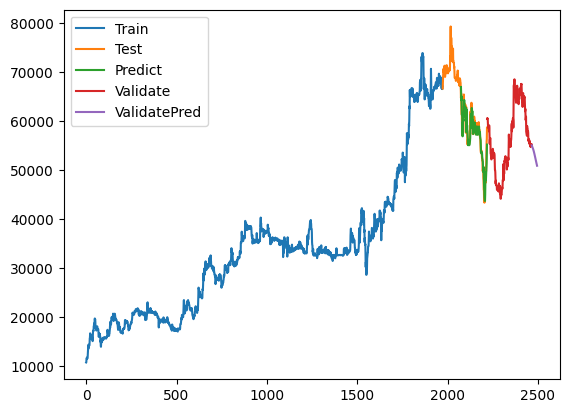

In [91]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
# plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()